<a href="https://colab.research.google.com/github/sodiq-sulaimon/Preparations-for-TensorFlow-Developer-Certification/blob/main/Time_Series/Training_a_Single_Layer_NN_with_Time_Series_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

### Generate synthethic data

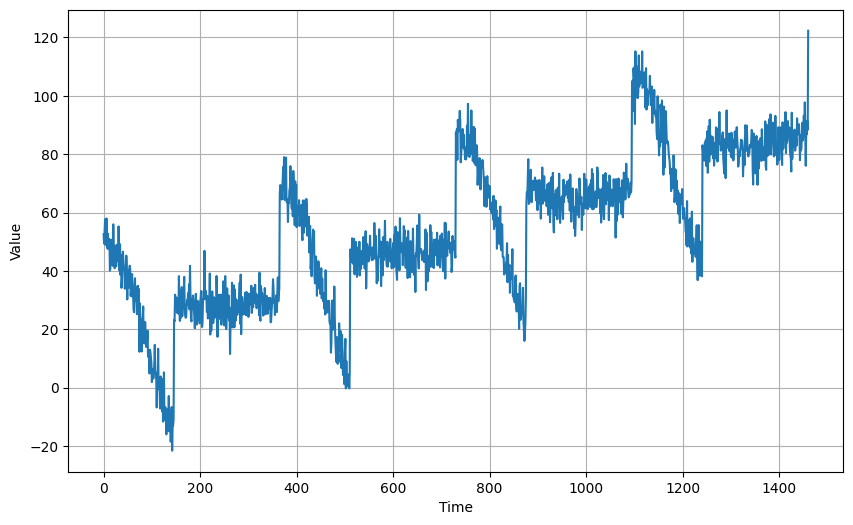

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

### Split the dataset

In [4]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

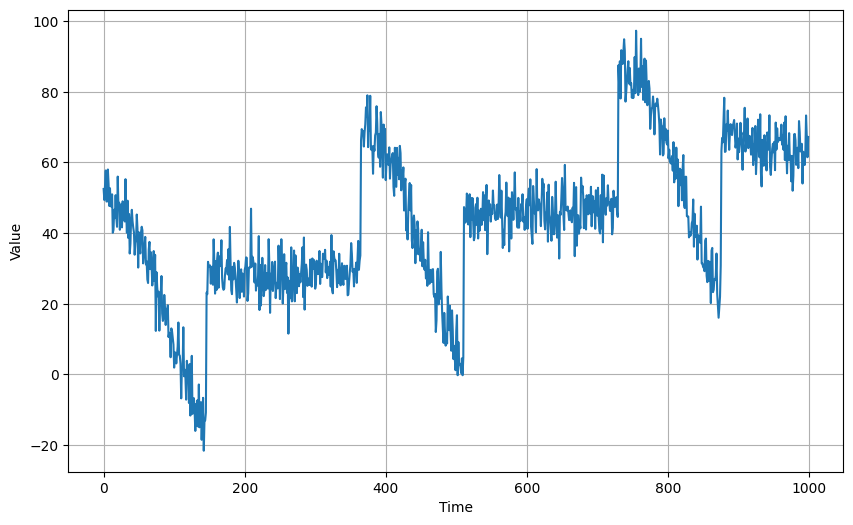

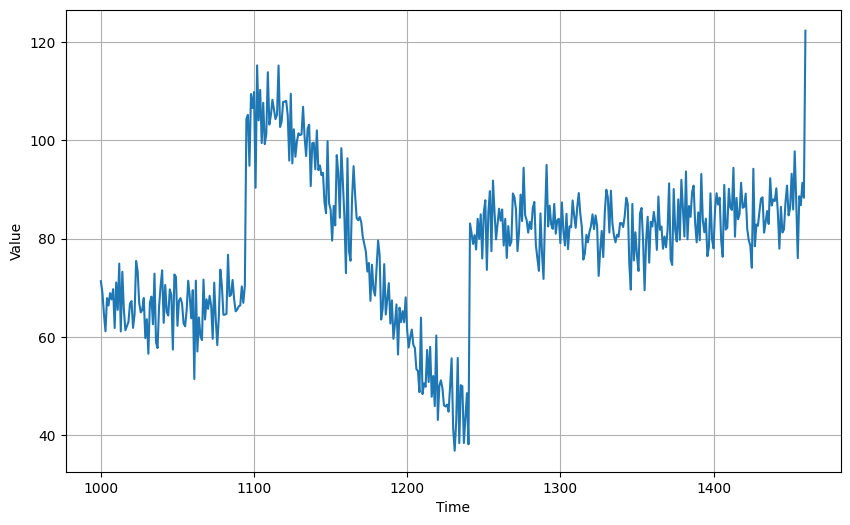

In [6]:
# Plot the data
plot_series(time_train, x_train)

plot_series(time_valid, x_valid)

### Prepare features and labels

In [7]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
    # Generate a tf dataset from the series
  dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # There is a + 1 to indicate that you're taking the next point as the label

  # Flatten the windows by putting the elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # Create tuples with features and labels
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  # Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Now we can generate the dataset windows from the train set.

In [12]:
dataset = windowed_dataset(x_train, window_size,batch_size,shuffle_buffer_size)

In [14]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')


data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


### Build and compile the model
We will assign the layer to a variable l0 so we can also look at the final weights later using the get_weights() method.

In [16]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.Sequential([l0])

# Print the initial layer weights
print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Layer weights: 
 [array([[-0.01838338],
       [ 0.07917279],
       [ 0.17320102],
       [-0.27159178],
       [-0.42663807],
       [ 0.26805788],
       [ 0.49391836],
       [ 0.21349746],
       [-0.32158792],
       [ 0.3601656 ],
       [-0.5306585 ],
       [ 0.3891912 ],
       [ 0.21541506],
       [ 0.36797482],
       [ 0.4511379 ],
       [-0.42337036],
       [ 0.5150253 ],
       [-0.16752496],
       [ 0.42220122],
       [ 0.14419818]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

### Train the model

In [18]:
model.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 6s 3ms/step - loss: 426.7005
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 125.3460
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 113.8780
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 109.2539
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 107.1288
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 103.2649
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 101.3008
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 100.7373
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 95.8299
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 92.1664
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 91.0151
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 89.0872
Epoch 13/100
31/3

In [20]:
# Print the final weights
print(f"Final weights: \n{l0.get_weights()}")

Final weights: 
[array([[-0.05819731],
       [ 0.02174238],
       [ 0.07125389],
       [-0.04331952],
       [-0.06125574],
       [ 0.05153216],
       [ 0.05396775],
       [ 0.02146173],
       [-0.08700366],
       [ 0.0881912 ],
       [-0.10651951],
       [ 0.04094896],
       [-0.03793561],
       [ 0.06451391],
       [ 0.06167899],
       [-0.04040221],
       [ 0.10164945],
       [ 0.11183251],
       [ 0.31713587],
       [ 0.4286324 ]], dtype=float32), array([0.01440578], dtype=float32)]


### Model Prediction

In [21]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 [==============================] - 0s 61ms/step
model prediction: [[43.979088]]


In [33]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Slice the points that are aligned with the validation set
forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

1/1 [==============================] - 0s 17ms/step
length of the forecast list: 461
shape of the validation set: (461,)


shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


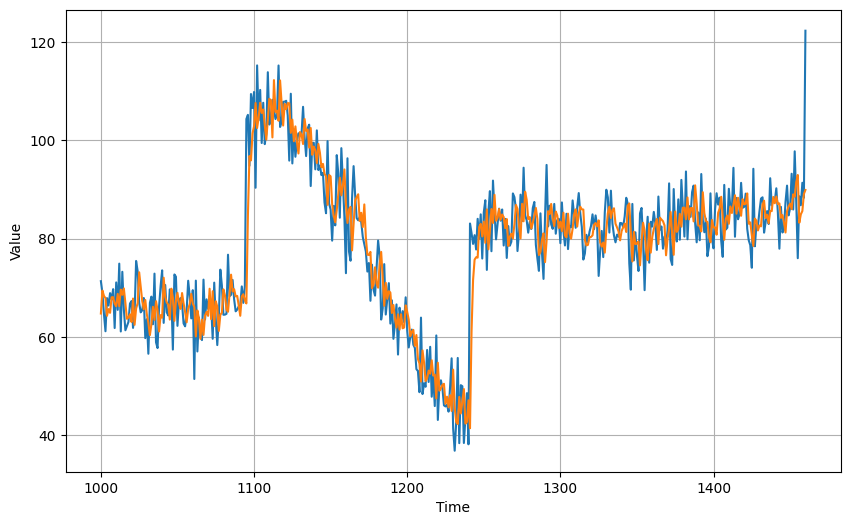

In [34]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results))

In [35]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

46.8717
5.1054254
